In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA

In [3]:
import nltk 
nltk.download('stopwords')
german_stop_words = stopwords.words('german')
english_stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/faten/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df_de = pd.read_csv("data/aspects_DE.csv").dropna(subset=["description"]).reset_index()
df_en = pd.read_csv("data/aspects_EN.csv").dropna(subset=["description"]).reset_index()

In [5]:
vectorizer_de = TfidfVectorizer(
    max_df=0.9,
    min_df=0.01,
    stop_words=german_stop_words,
)

vectorizer_en = TfidfVectorizer(
    max_df=0.9,
    min_df=0.01,
    stop_words=german_stop_words,
)

In [6]:
X_tfidf_de = vectorizer_de.fit_transform(df_de["description"])
print(f"n_samples: {X_tfidf_de.shape[0]}, n_features: {X_tfidf_de.shape[1]}")

X_tfidf_en = vectorizer_en.fit_transform(df_en["description"])
print(f"n_samples: {X_tfidf_en.shape[0]}, n_features: {X_tfidf_en.shape[1]}")

n_samples: 43614, n_features: 62
n_samples: 7324, n_features: 114


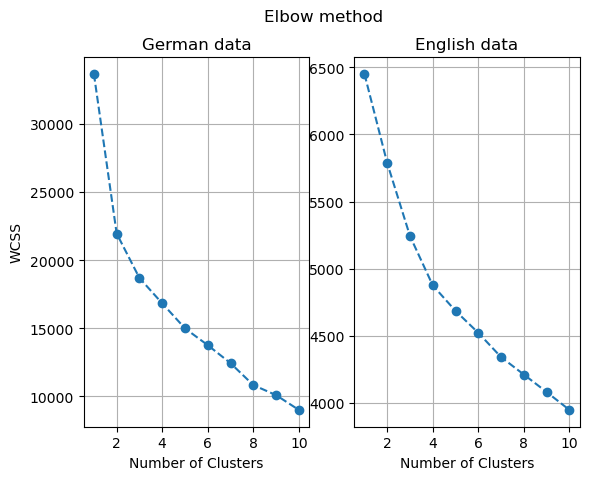

In [11]:
# Perform KMeans clustering for different number of clusters
fig, axs = plt.subplots(1, 2, sharex=True)

wcss_de = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_tfidf_de)
    wcss_de.append(kmeans.inertia_)

wcss_en = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_tfidf_en)
    wcss_en.append(kmeans.inertia_)

# Plot the elbow method graph
axs[0].plot(range(1, 11), wcss_de, marker='o', linestyle='--')
axs[1].plot(range(1, 11), wcss_en, marker='o', linestyle='--')

title = fig.suptitle("Elbow method")
axs[0].title.set_text('German data')
axs[1].title.set_text('English data')
axs[0].set_ylabel("WCSS")
axs[0].set_xlabel('Number of Clusters')
axs[1].set_xlabel('Number of Clusters')
axs[0].grid(True)
axs[1].grid(True)

In [7]:
X_pca_de = PCA(n_components=2).fit_transform(X_tfidf_de.toarray())
X_pca_en = PCA(n_components=2).fit_transform(X_tfidf_en.toarray())

In [8]:
k = 3
kmeans_de = KMeans(
    n_clusters=k,
    max_iter=100,
    n_init=3,
    random_state=42,
).fit(X_pca_de)

kmeans_en = KMeans(
    n_clusters=k,
    max_iter=100,
    n_init=3,
    random_state=42,
).fit(X_pca_en)


cluster_ids, cluster_sizes = np.unique(kmeans_de.labels_, return_counts=True)
L = cluster_sizes.sum()
print(f"Number of elements assigned to each cluster: {cluster_sizes}")
print("Cluster 1: {:.2f}%".format(cluster_sizes[0]/L * 100))
print("Cluster 2: {:.2f}%".format(cluster_sizes[1]/L * 100))
print("Cluster 3: {:.2f}%\n".format(cluster_sizes[2]/L * 100))

cluster_ids, cluster_sizes = np.unique(kmeans_en.labels_, return_counts=True)
L = cluster_sizes.sum()
print(f"Number of elements assigned to each cluster: {cluster_sizes}")
print("Cluster 1: {:.2f}%".format(cluster_sizes[0]/L * 100))
print("Cluster 2: {:.2f}%".format(cluster_sizes[1]/L * 100))
print("Cluster 3: {:.2f}%".format(cluster_sizes[2]/L * 100))

Number of elements assigned to each cluster: [17694 12574 13346]
Cluster 1: 40.57%
Cluster 2: 28.83%
Cluster 3: 30.60%

Number of elements assigned to each cluster: [5431  667 1226]
Cluster 1: 74.15%
Cluster 2: 9.11%
Cluster 3: 16.74%


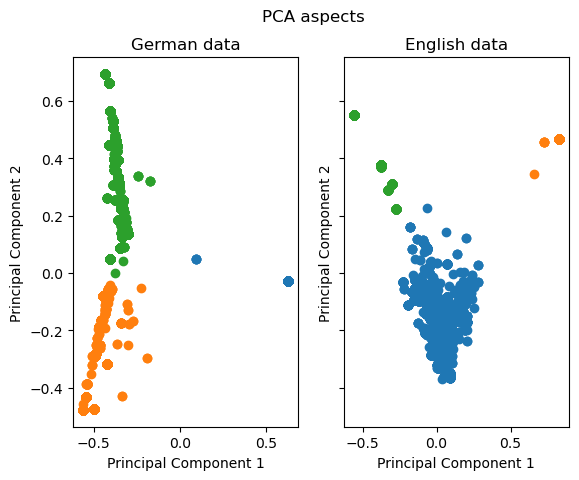

In [9]:
# Plotting
fig, axs = plt.subplots(1, 2, sharey=True)

for cluster in range(k):
    axs[0].scatter(X_pca_de[kmeans_de.labels_ == cluster, 0], X_pca_de[kmeans_de.labels_ == cluster, 1], label=f'Cluster {cluster+1}')

for cluster in range(k):
    axs[1].scatter(X_pca_en[kmeans_en.labels_ == cluster, 0], X_pca_en[kmeans_en.labels_ == cluster, 1], label=f'Cluster {cluster+1}')


fig.suptitle("PCA aspects")
axs[0].title.set_text('German data')
axs[1].title.set_text('English data')

axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 2')

axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')

# plt.legend()
plt.show()

**Looking closely at the aspects of each cluster**

In [ ]:
df_nb_aspect_per_task = df_de[["taskId", "aspectId"]].groupby("taskId").count().reset_index().rename(columns={"aspectId":"aspects"})
nbins = df_nb_aspect_per_task["aspects"].max()
df_nb_aspect_per_task.plot.hist(column=["aspects"], bins=nbins)

In [ ]:
print("Average number of aspects per task: {0:.1f}".format(df_nb_aspect_per_task["aspects"].mean()))

In [ ]:
df_nb_aspect_per_task = df_en[["taskId", "aspectId"]].groupby("taskId").count().reset_index().rename(columns={"aspectId":"aspects"})
nbins = df_nb_aspect_per_task["aspects"].max()
df_nb_aspect_per_task.plot.hist(column=["aspects"], bins=nbins)

In [ ]:
print("Average number of aspects per task: {0:.1f}".format(df_nb_aspect_per_task["aspects"].mean()))

In [ ]:
df_de["cluster"] = kmeans_de.labels_
df_task_cluster = df_de[["taskId","cluster"]].pivot_table(index="taskId", values="cluster", aggfunc=lambda x: len(list(x.unique())))
df_task_cluster["cluster"].unique()

In [ ]:
L = len(df_task_cluster)
print("Perct. of tasks belonging to one aspect cluster: {0:.2f}%".format(len(df_task_cluster[df_task_cluster["cluster"] == 1]) / L * 100))
print("Perct. of tasks belonging to two aspect clusters: {0:.2f}%".format(len(df_task_cluster[df_task_cluster["cluster"] == 2]) / L * 100))
print("Perct. of tasks belonging to all aspect clusters: {0:.2f}%".format(len(df_task_cluster[df_task_cluster["cluster"] == 3]) / L * 100))

In [ ]:
df_en["cluster"] = kmeans_en.labels_
df_task_cluster = df_en[["taskId","cluster"]].pivot_table(index="taskId", values="cluster", aggfunc=lambda x: len(list(x.unique())))
df_task_cluster["cluster"].unique()

In [ ]:
L = len(df_task_cluster)
print("Perct. of tasks belonging to one aspect cluster: {0:.2f}%".format(len(df_task_cluster[df_task_cluster["cluster"] == 1]) / L * 100))
print("Perct. of tasks belonging to two aspect clusters: {0:.2f}%".format(len(df_task_cluster[df_task_cluster["cluster"] == 2]) / L * 100))
print("Perct. of tasks belonging to all aspect clusters: {0:.2f}%".format(len(df_task_cluster[df_task_cluster["cluster"] == 3]) / L * 100))

> Tasks can belong to one, two or all the clusters of aspects. The vast majority belong to two clusters of aspects. Meaning that the vast majority of tasks are have aspects that are clustered in two different groups depending on their description.

In [ ]:
# Groups of aspects in each cluster
df_groups_per_cluster = df_de[["groupId","cluster"]].pivot_table(index="cluster", values="groupId", aggfunc=lambda x: list(x.unique()))

groups0 = df_groups_per_cluster.loc[0]["groupId"]
groups1 = df_groups_per_cluster.loc[1]["groupId"]
groups2 = df_groups_per_cluster.loc[2]["groupId"]

# Common groups between different clusters of aspects
print(f"Intersection of three clusters: {set(groups0).intersection(groups1, groups2)}")
print(f"Intersection of cluster 1 and cluster 2: {set(groups0).intersection(groups1)}")
print(f"Intersection of cluster 1 and cluster 3: {set(groups0).intersection(groups2)}")
print(f"Intersection of cluster 2 and cluster 3: {set(groups1).intersection(groups2)}")

In [ ]:
# Groups of aspects in each cluster
df_groups_per_cluster = df_en[["groupId","cluster"]].pivot_table(index="cluster", values="groupId", aggfunc=lambda x: list(x.unique()))

groups0 = df_groups_per_cluster.loc[0]["groupId"]
groups1 = df_groups_per_cluster.loc[1]["groupId"]
groups2 = df_groups_per_cluster.loc[2]["groupId"]

# Common groups between different clusters of aspects
print(f"Intersection of three clusters: {set(groups0).intersection(groups1, groups2)}")
print(f"Intersection of cluster 1 and cluster 2: {set(groups0).intersection(groups1)}")
print(f"Intersection of cluster 1 and cluster 3: {set(groups0).intersection(groups2)}")
print(f"Intersection of cluster 2 and cluster 3: {set(groups1).intersection(groups2)}")

In [ ]:
import mysql.connector
cnx = mysql.connector.connect(user='root', password='taskbase',
                              host='127.0.0.1', port='3309', database='lernnavi')
query = "SELECT * FROM AspectGroups"
df_groups = pd.read_sql(query, cnx)
# df_groups

In [ ]:
# Intersection of cluster 2 and cluster 3: {55122.0} in de aspects
df_groups[df_groups['id'] == 55122.0]

In [ ]:
# Intersection of cluster 1 and cluster 2: {133136.0, 123385.0, 123127.0}
df_groups[df_groups['id'] == 133136.0]

In [ ]:
df_groups[df_groups['id'] == 123385.0]

In [ ]:
df_groups[df_groups['id'] == 123127.0]

In [ ]:
# Intersection of cluster 1 and cluster 3: {55114.0, 55028.0, 55173.0, 54966.0}
df_groups[df_groups['id'] == 55114.0]

In [ ]:
df_groups[df_groups['id'] == 55028.0]

In [ ]:
df_groups[df_groups['id'] == 55173.0]

In [ ]:
df_groups[df_groups['id'] == 54966.0]

In [ ]:
# TODO How to represent each cluster of aspects? What is the difference in their content? 
# What semantics make these clusters differentiable? 